Made by: Andrei Kulchyk (155489) and Fiodar Piatrovich (155174)

[Github](https://github.com/aaakulchyk/put-evolutionary-computations)

# Description of a problem

We are given three columns of integers with a row for each node. The first two columns contain x and y coordinates of the node positions in a plane. The third column contains node costs. The goal is to select exactly 50% of the nodes (if the number of nodes is odd we round the number of nodes to be selected up) and form a Hamiltonian cycle (closed path) through this set of nodes such that the sum of the total length of the path plus the total cost of the selected nodes is minimized.

The distances between nodes are calculated as Euclidean distances rounded mathematically to
integer values. The distance matrix should be calculated just after reading an instance and then only
the distance matrix (no nodes coordinates) should be accessed by optimization methods to allow
instances defined only by distance matrices.

In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from scipy.stats import pearsonr  # for correlation

from hamiltonian_cycle.algorithms.lab1 import init_random_solution
from hamiltonian_cycle.algorithms.lab3_4 import LocalSearch
from hamiltonian_cycle.costs import dm, function_cost

In [3]:
def read_dataset_csv(csv_path: Path) -> pd.DataFrame:
    return pd.read_csv(csv_path, sep=";", names=["x", "y", "cost"])


DATA_DIR = Path("../data").resolve()

ds_a = read_dataset_csv(DATA_DIR / "TSPA.csv")
ds_b = read_dataset_csv(DATA_DIR / "TSPB.csv")

dm_a = dm(ds_a)
dm_b = dm(ds_b)

# Charts

In [4]:
class LSMetrics:
    def __init__(self, solution: pd.DataFrame):
        self.cost = function_cost(solution)
        self.solution = list(solution.index)


def run_ls_a(ls: LocalSearch) -> LSMetrics:
    ls_solution = ls(ds_a, dm_a, list(init_random_solution(ds_a, dm_a, 0).index))
    return LSMetrics(ls_solution)


def run_ls_b(ls: LocalSearch) -> LSMetrics:
    ls_solution = ls(ds_b, dm_b, list(init_random_solution(ds_b, dm_b, 0).index))
    return LSMetrics(ls_solution)


ls = LocalSearch(
    strategy="greedy",
    intra_search="edge",
    debug_mode=False,
)
ls_runs = 1000

In [5]:
metrics_a: list[LSMetrics] = Parallel(n_jobs=-1)(
    delayed(run_ls_a)(ls) for _ in range(ls_runs)
)


metrics_b: list[LSMetrics] = Parallel(n_jobs=-1)(
    delayed(run_ls_b)(ls) for _ in range(ls_runs)
)

In [15]:
def similarity_common_nodes(sol_a, sol_b):
    """
    Return the number of common selected nodes between two solutions.
    """
    set_a = set(sol_a)
    set_b = set(sol_b)
    return len(set_a & set_b)


def similarity_common_edges(sol_a, sol_b):
    arcs_a = set()
    for i in range(len(sol_a)):
        j = (i + 1) % len(sol_a)  # next index in a cycle
        edge = tuple(sorted((sol_a[i], sol_a[j])))
        arcs_a.add(edge)
    
    # Build set of edges for sol_b
    arcs_b = set()
    for i in range(len(sol_b)):
        j = (i + 1) % len(sol_b)
        edge = tuple(sorted((sol_b[i], sol_b[j])))
        arcs_b.add(edge)
    
    # Intersection
    return len(arcs_a & arcs_b)

In [16]:
best_a = min(metrics_a, key=lambda m: m.cost)
best_b = min(metrics_b, key=lambda m: m.cost)

In [17]:
def average_similarity_nodes(metrics_list, current_idx):
    # metrics_list is the full list of LSMetrics
    # current_idx is the index of the current solution
    # compute average similarity to all other solutions
    sol_current = metrics_list[current_idx].solution
    total_sim = 0.0
    count = len(metrics_list) - 1
    for i, m in enumerate(metrics_list):
        if i != current_idx:
            total_sim += similarity_common_nodes(sol_current, m.solution)
    return total_sim / count


In [18]:
def prepare_data_for_plot(
    metrics_list, instance_name, best_sol, measure_func, measure_name, similarity_kind
):
    """
    - metrics_list: list of LSMetrics
    - instance_name: "A" or "B"
    - best_sol: the best LSMetrics object for this instance
    - measure_func: one of {similarity_common_nodes, similarity_common_edges}
    - measure_name: "nodes" or "edges"
    - similarity_kind: "best" or "average"

    Return: A DataFrame with columns [cost, similarity, measure_type, similarity_kind, instance]
    """

    records = []

    if similarity_kind == "best":
        # Exclude the best solution from the final chart
        for m in metrics_list:
            if m is not best_sol:
                sim_value = measure_func(m.solution, best_sol.solution)
                records.append(
                    {
                        "cost": m.cost,
                        "similarity": sim_value,
                        "measure_type": measure_name,
                        "similarity_kind": similarity_kind,
                        "instance": instance_name,
                    }
                )

    elif similarity_kind == "average":
        # Compute average similarity to all other solutions
        for i, m in enumerate(metrics_list):
            sol_current = m.solution
            sim_value = 0.0
            for j, n in enumerate(metrics_list):
                if j != i:
                    sim_value += measure_func(sol_current, n.solution)
            sim_value /= len(metrics_list) - 1
            records.append(
                {
                    "cost": m.cost,
                    "similarity": sim_value,
                    "measure_type": measure_name,
                    "similarity_kind": similarity_kind,
                    "instance": instance_name,
                }
            )

    return pd.DataFrame(records)


In [19]:
# Identify best solutions
best_a = min(metrics_a, key=lambda m: m.cost)
best_b = min(metrics_b, key=lambda m: m.cost)

df_list = []

# Instance A
df_list.append(
    prepare_data_for_plot(
        metrics_a, "A", best_a, similarity_common_nodes, "nodes", "best"
    )
)
df_list.append(
    prepare_data_for_plot(
        metrics_a, "A", best_a, similarity_common_nodes, "nodes", "average"
    )
)
df_list.append(
    prepare_data_for_plot(
        metrics_a, "A", best_a, similarity_common_edges, "edges", "best"
    )
)
df_list.append(
    prepare_data_for_plot(
        metrics_a, "A", best_a, similarity_common_edges, "edges", "average"
    )
)

# Instance B
df_list.append(
    prepare_data_for_plot(
        metrics_b, "B", best_b, similarity_common_nodes, "nodes", "best"
    )
)
df_list.append(
    prepare_data_for_plot(
        metrics_b, "B", best_b, similarity_common_nodes, "nodes", "average"
    )
)
df_list.append(
    prepare_data_for_plot(
        metrics_b, "B", best_b, similarity_common_edges, "edges", "best"
    )
)
df_list.append(
    prepare_data_for_plot(
        metrics_b, "B", best_b, similarity_common_edges, "edges", "average"
    )
)

df_final = pd.concat(df_list, ignore_index=True)


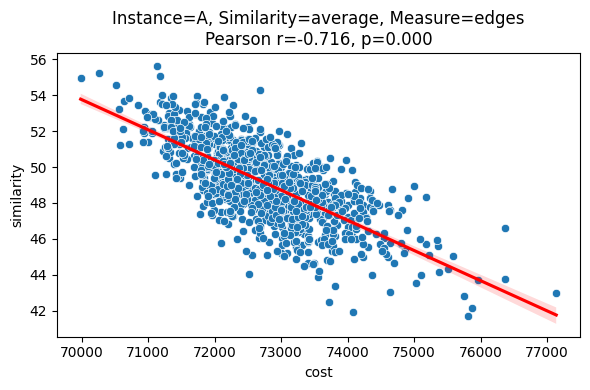

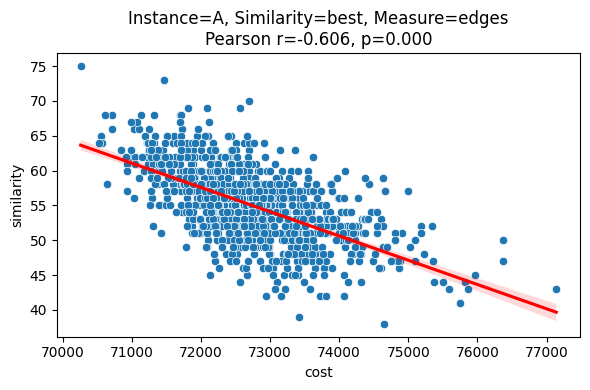

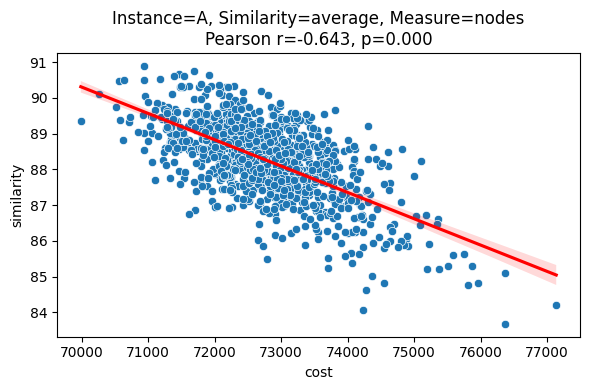

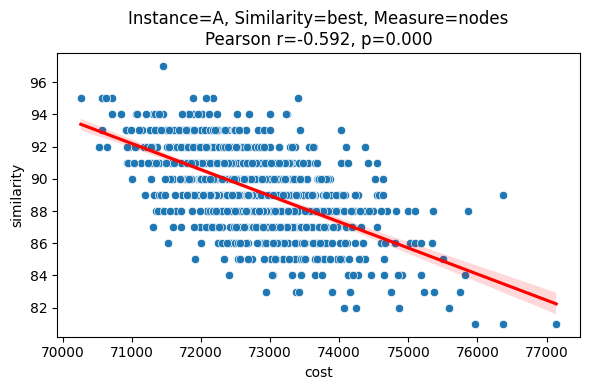

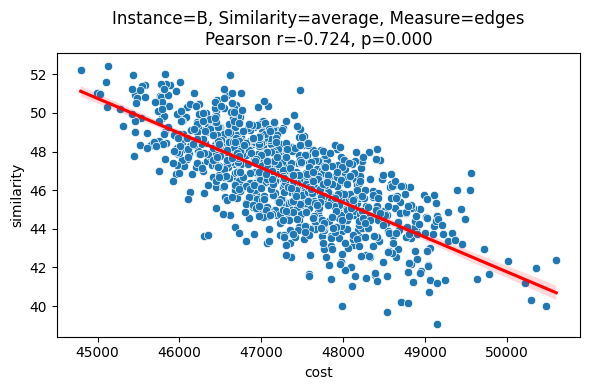

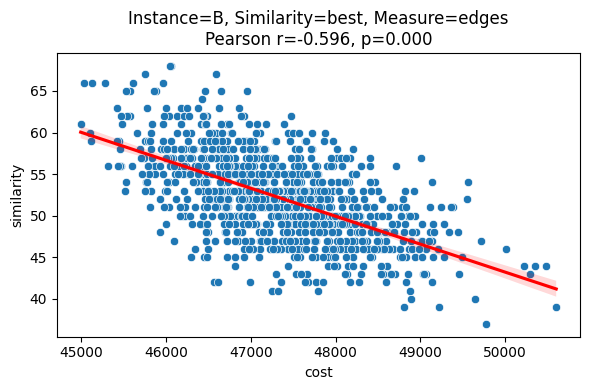

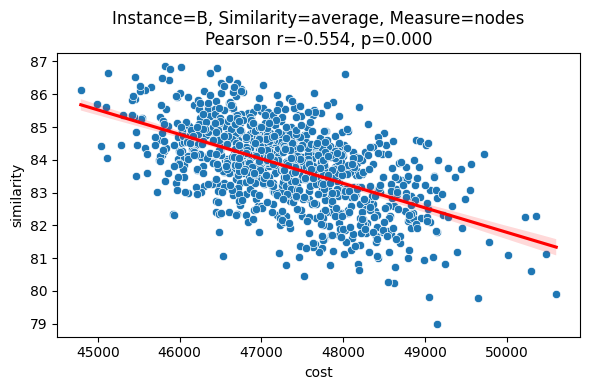

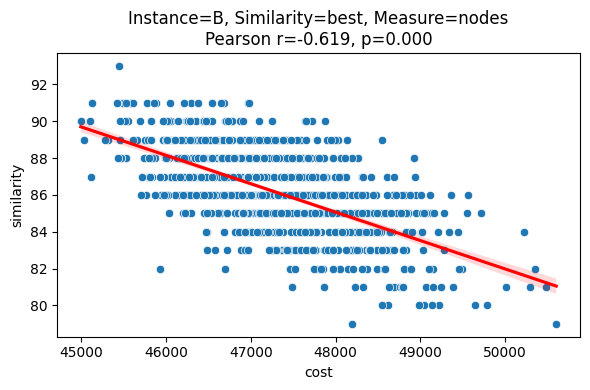

In [20]:
# Option 1: A loop that creates separate figures.
groups = df_final.groupby(["instance", "measure_type", "similarity_kind"])

for (instance_name, measure_type, sim_kind), subdf in groups:
    # Compute correlation
    r_value, p_value = pearsonr(subdf["cost"], subdf["similarity"])

    # Create a figure
    plt.figure(figsize=(6, 4))

    sns.scatterplot(data=subdf, x="cost", y="similarity")
    sns.regplot(data=subdf, x="cost", y="similarity", scatter=False, color="red")

    # Round to 3 decimal places
    plt.title(
        f"Instance={instance_name}, Similarity={sim_kind}, Measure={measure_type}\n"
        f"Pearson r={r_value:.3f}, p={p_value:.3f}"
    )

    plt.tight_layout()
    plt.show()


In [40]:
# best_a.cost, best_b.cost

# Conclusion

1. Correlations presented by the plots are representative, due to small `p` value emerged from statistical significance tests. In other words, 1000 runs of LS were enough.
2. There is a negative correlation between cost and similarity for all the kind of comparisons.
3. Similarity of the local optimas belong to fixed interval, depending on solution and comparison it would be [20%, 50%] of the maximal possible similarity (200). In other words, we could state that local optimas are 20% to 50% similar.
4. Node similarities are higher than edge similarity, for it's (to have similar nodes in solutions) a necessary condition for edge similarity (to have edge between them).
5. Generarly, both nodes and edges similarities are are higher when compared to the best solution.